In [1]:

import os
import wandb
import requests
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Using device: {device}")

# set repeatability
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)     # Set a random seed for CUDA operations.
    torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
    
    # Ensure deterministic behavior for CUDA operations (note: If you are not concerned with reportable reproducibility, set deterministic to false, and benchmark to true - as it can choose faster algorithms).
    torch.backends.cudnn.deterministic = True  # Set cuDNN to deterministic mode - it will now only select algorithms that are known to be deterministic.
    torch.backends.cudnn.benchmark = False  # Disable cuDNN benchmarking - it may select the best algorithms for the hardware, but it doesn't guarantee deterministic results.   

Using device: cuda


In [2]:

def fetch_weather_data():
    url = "https://archive-api.open-meteo.com/v1/era5?latitude=52.52&longitude=13.41&start_date=1990-01-01&end_date=2023-12-31&hourly=temperature_2m,relative_humidity_2m,wind_speed_10m"
    response = requests.get(url)
    data = response.json()
    return data


In [3]:
def time_series_split(df, train_ratio=0.7, val_ratio=0.15):
    train_size = int(len(df) * train_ratio)
    val_size = int(len(df) * val_ratio)
    
    train_data = df.iloc[:train_size]
    val_data = df.iloc[train_size:train_size + val_size]
    test_data = df.iloc[train_size + val_size:]
    
    return train_data, val_data, test_data

In [4]:


def process_data(data, seq_len=4):
    df = pd.DataFrame({
        "time": pd.to_datetime(data["hourly"]["time"]),
        "temperature": data["hourly"]["temperature_2m"],
        "humidity": data["hourly"]["relative_humidity_2m"],
        "wind_speed": data["hourly"]["wind_speed_10m"]
    })
    
    df.sort_values("time", inplace=True)
    df.drop(columns=["time"], inplace=True)
    
    # Perform a random 70-15-15 split before normalization
    train_data, val_data, test_data = time_series_split(df)
    
    # Normalize each split separately using training set statistics
    scaler = MinMaxScaler()
    train_data = pd.DataFrame(scaler.fit_transform(train_data), columns=df.columns, index=train_data.index)
    val_data = pd.DataFrame(scaler.transform(val_data), columns=df.columns, index=val_data.index)
    test_data = pd.DataFrame(scaler.transform(test_data), columns=df.columns, index=test_data.index)
    
    def create_sequences(data):
        sequences, targets = [], []
        for i in range(len(data) - seq_len):
            sequences.append(data.iloc[i:i+seq_len].values)
            targets.append(data.iloc[i+seq_len]["temperature"])  # Predict only temperature
        return np.array(sequences), np.array(targets)
    
    X_train, y_train = create_sequences(train_data)
    X_val, y_val = create_sequences(val_data)
    X_test, y_test = create_sequences(test_data)
    
    return X_train, y_train, X_val, y_val, X_test, y_test, scaler

In [5]:
wandb_api_key = "dc94a6f2fb35e68dd0ce5b185a38960232124958"
if wandb_api_key:
    wandb.login(key=wandb_api_key)
else:
    raise ValueError("WANDB_API_KEY environment variable not set!")

# Load the API key from the environment variable
wandb.init(project="Assignment6", entity="usf-magma", config={
    "learning_rate": 0.0005,
    "dropout": 0.4,
    "batch_size": 64,
    "epochs": 8,
    "momentum": (0.9, 0.92),
    "weight_decay": 1e-5,
    "optimizer": "Adam",
    "criterion": "MSE",  # Changed to MAE
    "input_size": 1,
    "hidden_size": 16
})

config = wandb.config

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\Gonax133\_netrc
wandb: Currently logged in as: montoyaruiz (usf-magma) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [6]:
def prepare_dataloader(X, y, batch_size):
    """Create a DataLoader from given features and targets."""
    dataset = TensorDataset(torch.tensor(X, dtype=torch.float32), 
                            torch.tensor(y, dtype=torch.float32).unsqueeze(1))
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [7]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, save_dir, device):
    """Train the model, log metrics, and save the best model based on validation loss."""

    model.to(device)  # Move model to device (CPU/GPU)
    train_losses, val_losses = [], []
    train_mae, val_mae = [], []
    best_loss = float("inf")  # Track best validation loss
    best_mae = float("inf")   # Track lowest validation MAE

    for epoch in range(num_epochs):
        model.train()
        running_loss, running_mae = 0.0, 0.0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)  # Move batch to GPU/CPU
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            running_mae += nn.functional.l1_loss(y_pred, y_batch).item()

        train_loss_epoch = running_loss / len(train_loader)
        train_mae_epoch = running_mae / len(train_loader)
        train_losses.append(train_loss_epoch)
        train_mae.append(train_mae_epoch)

        # Validation
        model.eval()
        val_loss, val_mae_epoch = 0.0, 0.0
        with torch.no_grad():
            for X_val_batch, y_val_batch in val_loader:
                X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)  # Move to GPU/CPU
                y_val_pred = model(X_val_batch)
                val_loss += criterion(y_val_pred, y_val_batch).item()
                val_mae_epoch += nn.functional.l1_loss(y_val_pred, y_val_batch).item()

        val_loss_epoch = val_loss / len(val_loader)
        val_mae_epoch = val_mae_epoch / len(val_loader)
        val_losses.append(val_loss_epoch)
        val_mae.append(val_mae_epoch)

        print(f"Epoch {epoch+1}/{num_epochs} -> Train Loss: {train_loss_epoch:.4f}, Val Loss: {val_loss_epoch:.4f}, Train MAE: {train_mae_epoch:.4f}, Val MAE: {val_mae_epoch:.4f}")

        # Log to wandb
        wandb.log({
            "Train Loss": train_loss_epoch,
            "Validation Loss": val_loss_epoch,
            "Train MAE": train_mae_epoch,
            "Validation MAE": val_mae_epoch
        })

        # Save the best model based on validation loss
        if val_loss_epoch < best_loss:
            best_loss = val_loss_epoch
            best_mae = val_mae_epoch  # Track best MAE
            model_save_path = os.path.join(save_dir, f"dual_rnn_best_epoch_{epoch+1}.pth")
            torch.save(model.state_dict(), model_save_path)
            wandb.save(model_save_path)
            print(f"Model saved: {model_save_path}")

            # Update wandb summary with best values
            wandb.run.summary["Best Validation Loss"] = best_loss
            wandb.run.summary["Best Validation MAE"] = best_mae

    # Plot Train Loss vs Validation Loss
    plt.figure(figsize=(10,5))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Train Loss vs Validation Loss")
    plt.legend()
    plt.show()

    # Plot Train MAE vs Validation MAE
    plt.figure(figsize=(10,5))
    plt.plot(train_mae, label="Train MAE")
    plt.plot(val_mae, label="Validation MAE")
    plt.xlabel("Epochs")
    plt.ylabel("MAE")
    plt.title("Train MAE vs Validation MAE")
    plt.legend()
    plt.show()

    return model


In [8]:

from sklearn.metrics import mean_squared_error

def evaluate_model(model, test_loader, scaler, device):
    """Evaluate the model on the test set and plot Actual vs Prediction."""
    model.to(device)  # Ensure model is on the correct device
    model.eval()

    actuals, predictions = [], []
    
    with torch.no_grad():
        for X_test_batch, y_test_batch in test_loader:
            X_test_batch, y_test_batch = X_test_batch.to(device), y_test_batch.to(device)  # Move to GPU/CPU
            y_test_pred = model(X_test_batch)

            # Convert tensors to NumPy
            y_test_pred_np = y_test_pred.cpu().numpy().reshape(-1, 1)
            y_test_actual_np = y_test_batch.cpu().numpy().reshape(-1, 1)

            # Apply inverse transform correctly
            y_test_pred_original = scaler.inverse_transform(
                np.column_stack((y_test_pred_np, np.zeros_like(y_test_pred_np), np.zeros_like(y_test_pred_np)))
            )[:, 0]  # Extract only the temperature column

            y_test_actual_original = scaler.inverse_transform(
                np.column_stack((y_test_actual_np, np.zeros_like(y_test_actual_np), np.zeros_like(y_test_actual_np)))
            )[:, 0]  # Extract only the temperature column

            actuals.extend(y_test_actual_original.tolist())
            predictions.extend(y_test_pred_original.tolist())

    # Compute final MSE
    test_mse = mean_squared_error(actuals, predictions)
    print(f"Test MSE: {test_mse:.4f}")

    # Print first 10 actual and predicted values
    print("First 10 Actual Values: ", actuals[:10])
    print("First 10 Predicted Values: ", predictions[:10])

    # Plot Actual vs Predicted Values
    plt.figure(figsize=(10,5))
    plt.scatter(actuals, predictions, alpha=0.5, label="Predicted vs Actual")
    plt.plot([min(actuals), max(actuals)], [min(actuals), max(actuals)], color='red', linestyle='--', label="Perfect Prediction")
    plt.xlabel("Actual Temperature")
    plt.ylabel("Predicted Temperature")
    plt.title("Actual vs Predicted Temperature")
    plt.legend()
    plt.show()

    return test_mse

In [9]:

    
class MultiHeadRNN(nn.Module):
    def __init__(self):
        super(MultiHeadRNN, self).__init__()
        self.rnn_temp = nn.RNN(input_size=1, hidden_size=config.hidden_size, num_layers=1, batch_first=True)
        self.rnn_hum = nn.RNN(input_size=1, hidden_size=config.hidden_size, num_layers=1, batch_first=True)
        self.rnn_wind = nn.RNN(input_size=1, hidden_size=config.hidden_size, num_layers=1, batch_first=True)
        self.fc1 = nn.Linear(config.hidden_size * 3, config.hidden_size)
        self.fc2 = nn.Linear(config.hidden_size, 1)
        self.dropout = nn.Dropout(config.dropout)
    
    def forward(self, x):
        x_temp = x[:, :, 0].unsqueeze(-1)  # Extract temperature
        x_hum = x[:, :, 1].unsqueeze(-1)   # Extract humidity
        x_wind = x[:, :, 2].unsqueeze(-1)  # Extract wind speed

        out_temp, _ = self.rnn_temp(x_temp)
        out_hum, _ = self.rnn_hum(x_hum)
        out_wind, _ = self.rnn_wind(x_wind)

        last_temp = out_temp[:, -1, :]
        last_hum = out_hum[:, -1, :]
        last_wind = out_wind[:, -1, :]
        combined = torch.cat([last_temp, last_hum, last_wind], dim=1)
        combined_1 = self.dropout(torch.tanh(self.fc1(combined)))
        prediction = self.fc2(combined_1)
        return prediction



Using device: cuda
(208618, 4, 3) (208618,)
[[[0.34232715 0.92592593 0.06054688]
  [0.34232715 0.90123457 0.06445312]
  [0.33895447 0.85185185 0.06445312]
  [0.34064081 0.81481481 0.0703125 ]]

 [[0.34232715 0.90123457 0.06445312]
  [0.33895447 0.85185185 0.06445312]
  [0.34064081 0.81481481 0.0703125 ]
  [0.33726813 0.80246914 0.078125  ]]]
[0.33726813 0.33895447]
Epoch 1/8 -> Train Loss: 0.0134, Val Loss: 0.0003, Train MAE: 0.0773, Val MAE: 0.0128
Model saved: saved_models\dual_rnn_best_epoch_1.pth
Epoch 2/8 -> Train Loss: 0.0012, Val Loss: 0.0002, Train MAE: 0.0242, Val MAE: 0.0098
Model saved: saved_models\dual_rnn_best_epoch_2.pth
Epoch 3/8 -> Train Loss: 0.0009, Val Loss: 0.0002, Train MAE: 0.0216, Val MAE: 0.0111
Epoch 4/8 -> Train Loss: 0.0009, Val Loss: 0.0001, Train MAE: 0.0211, Val MAE: 0.0085
Model saved: saved_models\dual_rnn_best_epoch_4.pth
Epoch 5/8 -> Train Loss: 0.0009, Val Loss: 0.0002, Train MAE: 0.0208, Val MAE: 0.0096
Epoch 6/8 -> Train Loss: 0.0009, Val Loss: 0.0

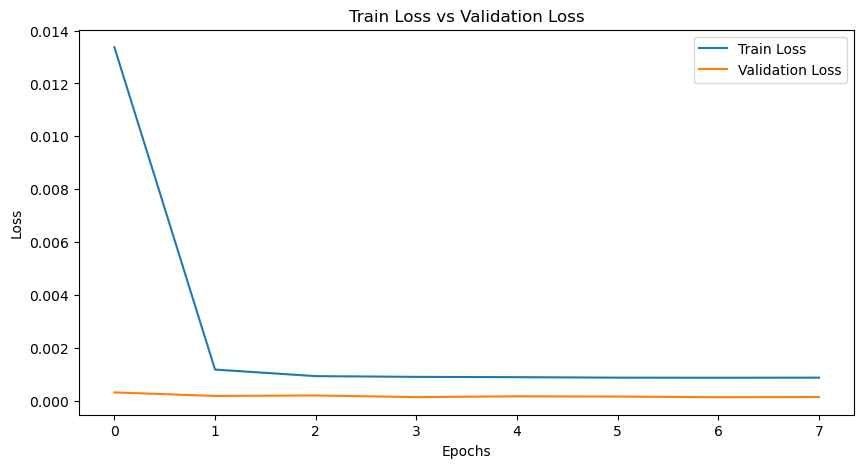

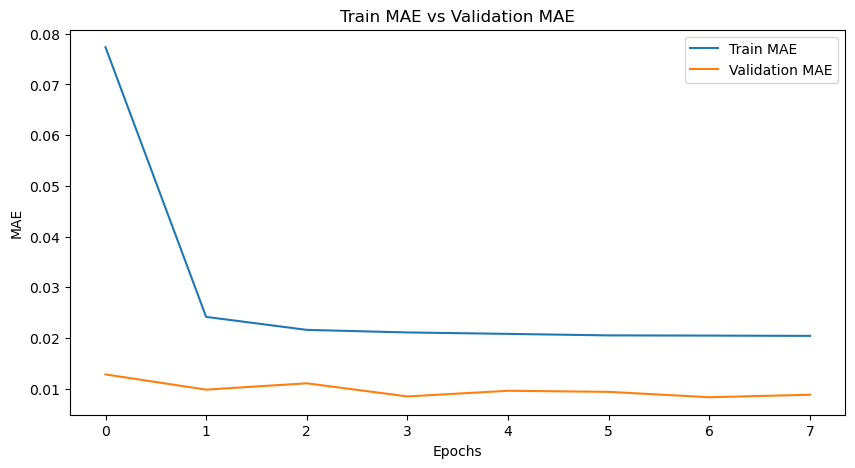

✅ Final model saved: saved_models\multihead_rnn_final.pth
Test MSE: 0.6471
First 10 Actual Values:  [9.199999809265137, 9.000000953674316, 11.199999809265137, 12.500001907348633, 25.19999885559082, -0.4999994933605194, 4.599999904632568, 8.60000228881836, 16.39999771118164, 7.500000476837158]
First 10 Predicted Values:  [9.7111177444458, 9.535609245300293, 10.832197189331055, 13.095793724060059, 24.39255714416504, -0.5064854025840759, 4.410325050354004, 7.994645595550537, 16.017629623413086, 7.925294399261475]


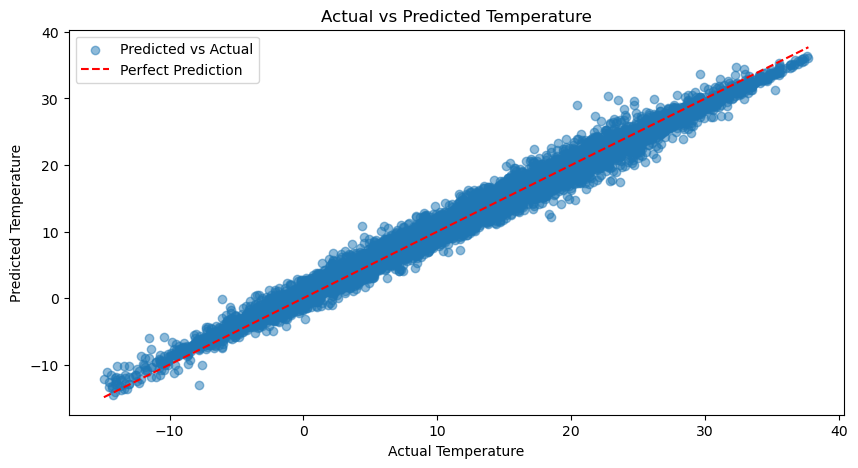

Train Loss,█▁▁▁▁▁▁▁
Train MAE,█▁▁▁▁▁▁▁
Validation Loss,█▃▄▁▂▂▁▁
Validation MAE,█▃▅▁▃▃▁▂
Best Validation Loss,0.00013
Best Validation MAE,0.00834
Train Loss,0.00087
Train MAE,0.02043
Validation Loss,0.00013
Validation MAE,0.00883


In [10]:
if __name__ == "__main__":
    import os
    import torch

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Create a folder for saving models if it doesn't exist
    save_dir = "saved_models"
    os.makedirs(save_dir, exist_ok=True)

    data = fetch_weather_data()
    X_train, y_train, X_val, y_val, X_test, y_test, scaler = process_data(data)
    print(X_train.shape, y_train.shape)  # Debe ser (num_samples, SEQ_LEN, 3) y (num_samples,)
    print(X_train[:2])  # Muestra las primeras secuencias para verificar estructura
    print(y_train[:2])  # Muestra los valores esperados

    # Prepare data loaders
    train_loader = prepare_dataloader(X_train, y_train, config.batch_size)
    val_loader = prepare_dataloader(X_val, y_val, config.batch_size)
    test_loader = prepare_dataloader(X_test, y_test, config.batch_size)

    # Initialize model, loss function, and optimizer
    model = MultiHeadRNN().to(device)  # Move model to correct device
    criterion = nn.MSELoss()  # MSE Loss
    #criterion = nn.L1Loss()  # MAE Loss
    optimizer = optim.Adam(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)

    # Train the model
    model = train_model(model, train_loader, val_loader, criterion, optimizer, config.epochs, save_dir, device)

    # Save final model
    final_model_path = os.path.join(save_dir, "multihead_rnn_final.pth")
    torch.save(model.state_dict(), final_model_path)
    wandb.save(final_model_path)
    print(f"✅ Final model saved: {final_model_path}")

    # Evaluate the model on test data
    evaluate_model(model, test_loader, scaler,device)

    # Finish wandb logging
    wandb.finish()